In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.corpora import Dictionary

In [2]:
### Data Cleaning

# Load the dataset
df = pd.read_csv('UserCourseTranscripts_2023-10-12-14-54-23.csv', low_memory=False)

# Keep only the rows with 'Course Evaluation' in the 'Module' column
df = df[df['Module'] == 'Course Evaluation']

# Define the list of values you want to filter
filter_values = ['Stu15 Which part(s) of the course was MOST valuable to you? Please explain why.', 
                 'Stu16 Which part(s) of the course was LEAST valuable to you? Please explain why.', 
                 'Stu17 Please provide any other comments or suggestions you have for improving this course']

# Use boolean indexing to filter the DataFrame
df = df[df['Interaction Description'].isin(filter_values)]

# Select the desired columns
df = df[['Interaction Description', 'Learner Response']]

# Drop all blank rows (assuming 'Learner Response' is the column with text data)
df = df.dropna(subset=['Learner Response'])

# Replace variations of 'N/A', 'n/a', etc. with NaN
df = df.replace(['N/A', 'n/a', 'N/A', 'nA', 'NA', 'na', 'n.a', 'N.A', 'NONE', 'none', 'None', 'unknown', 'Unknown'], pd.NA)

# Drop rows with NaN values in specific columns (e.g., 'Learner Response' column)
df.dropna(subset=['Learner Response'], inplace=True)

# Create a boolean mask to identify rows with only special characters
special_char_mask_1 = df['Learner Response'].str.match(r'^[?]+$')
special_char_mask_2 = df['Learner Response'].str.match(r'^[.]+$')
special_char_mask_3 = df['Learner Response'].str.match(r'^[-]+$')
special_char_mask_4 = df['Learner Response'].str.match(r'^[!]+$')
special_char_mask_5 = df['Learner Response'].str.match(r'^[..]+$')
# Drop rows with only special characters
df = df[~special_char_mask_1]
df = df[~special_char_mask_2]
df = df[~special_char_mask_3]
df = df[~special_char_mask_4]
df = df[~special_char_mask_5]

# Get the texts as a list
preprocessed_text = df['Learner Response'].tolist()

/var/folders/nw/t4r23zl55bv4x0dcsmgsbw6r0000gn/T/ipykernel_15110/469336936.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~special_char_mask_2]
/var/folders/nw/t4r23zl55bv4x0dcsmgsbw6r0000gn/T/ipykernel_15110/469336936.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~special_char_mask_3]
/var/folders/nw/t4r23zl55bv4x0dcsmgsbw6r0000gn/T/ipykernel_15110/469336936.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~special_char_mask_4]
/var/folders/nw/t4r23zl55bv4x0dcsmgsbw6r0000gn/T/ipykernel_15110/469336936.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~special_char_mask_5]


In [3]:
### Data Preprocessing

# Define a stemming function
stemmer = PorterStemmer()

# Define a function for preprocessing
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and tokenize into terms
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # Remove non-alphabetic characters

    # Remove stop words ##### check specific stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    # Stem the words --- reduce the variation in the text data by converting words to their common base form/word stem.
    tokens = [stemmer.stem(t) for t in tokens]

    return tokens

In [4]:
# Apply the preprocessing function to each 'Learner Response' in df
df['preprocessed_text'] = df['Learner Response'].apply(preprocess)

# Create a Dictionary based on the preprocessed text
dictionary = Dictionary(df['preprocessed_text'])

# Create a Term-Document Matrix (corpus) for the preprocessed text
corpus = [dictionary.doc2bow(text) for text in df['preprocessed_text']]

In [5]:
# # Apply the preprocessing function to each Learner Response in the dataset
# df['preprocessed_text'] = df['Learner Response'].apply(preprocess)

# # Create a Dictionary and Term-Document Matrix
# dictionary = Dictionary(data['preprocessed_text'])
# corpus = [dictionary.doc2bow(text) for text in data['preprocessed_text']]

In [17]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import time

num_topics_range = range(2, 41)
perplexity_scores = []
elapsed_times = []

for num_topics in num_topics_range:
    start_time = time.time()

    # Train the LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)

    # Record the elapsed time
    elapsed_time = time.time() - start_time
    elapsed_times.append(elapsed_time)

    print(f"Number of topics: {num_topics}, Perplexity: {perplexity}, Time elapsed: {elapsed_time} seconds")

Number of topics: 2, Perplexity: -6.37788531475882, Time elapsed: 0.3681802749633789 seconds
Number of topics: 3, Perplexity: -6.502052494006919, Time elapsed: 0.30457496643066406 seconds
Number of topics: 4, Perplexity: -6.615420576067797, Time elapsed: 0.2412090301513672 seconds
Number of topics: 5, Perplexity: -6.687840411838071, Time elapsed: 0.211043119430542 seconds
Number of topics: 6, Perplexity: -6.777883584967126, Time elapsed: 0.20001721382141113 seconds
Number of topics: 7, Perplexity: -6.788700389641136, Time elapsed: 0.19327306747436523 seconds
Number of topics: 8, Perplexity: -6.912107340715545, Time elapsed: 0.1954329013824463 seconds
Number of topics: 9, Perplexity: -6.969368754981601, Time elapsed: 0.24845480918884277 seconds
Number of topics: 10, Perplexity: -6.999062165512837, Time elapsed: 0.19544196128845215 seconds
Number of topics: 11, Perplexity: -7.058740391180145, Time elapsed: 0.1910109519958496 seconds
Number of topics: 12, Perplexity: -7.1028292571890495, 

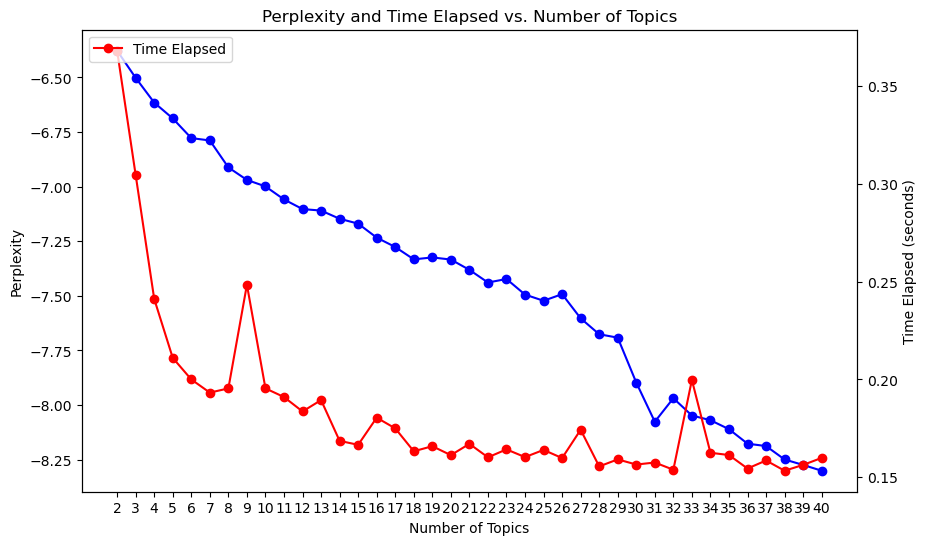

In [18]:
# Create a single combined plot for both perplexity and time elapsed
plt.figure(figsize=(10, 6))

# Plot perplexity with a label
plt.plot(list(num_topics_range), perplexity_scores, marker='o', color='blue')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity and Time Elapsed vs. Number of Topics')

# Create a secondary y-axis for time elapsed
plt.twinx()
plt.plot(list(num_topics_range), elapsed_times, marker='o', color='red')
plt.ylabel('Time Elapsed (seconds)')

# Set integer ticks on the x-axis
plt.xticks(list(num_topics_range))

# Add legends manually
plt.legend(['Time Elapsed', 'Perplexity'], loc='upper left')

plt.show()

In [9]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various numbers of topics

    Parameters:
    - dictionary: Gensim dictionary
    - corpus: Gensim corpus
    - texts: List of preprocessed texts
    - limit: Max number of topics
    - start: Min number of topics
    - step: Step between each number of topics

    Returns:
    - model_list: List of LDA topic models
    - coherence_values: Coherence values corresponding to the LDA model with respective topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Define the range of topics to explore
start = 2  # Minimum number of topics
limit = 10  # Maximum number of topics
step = 1  # Step size between number of topics

# Call the function to compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['preprocessed_text'], start=start, limit=limit, step=step)

# Print the coherence values for different models
for num_topics, coherence_score in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics: {num_topics}  - Coherence Score: {coherence_score:.4f}")

Num Topics: 2  - Coherence Score: 0.3439
Num Topics: 3  - Coherence Score: 0.3656
Num Topics: 4  - Coherence Score: 0.3740
Num Topics: 5  - Coherence Score: 0.4022
Num Topics: 6  - Coherence Score: 0.4239
Num Topics: 7  - Coherence Score: 0.3792
Num Topics: 8  - Coherence Score: 0.4071
Num Topics: 9  - Coherence Score: 0.4122


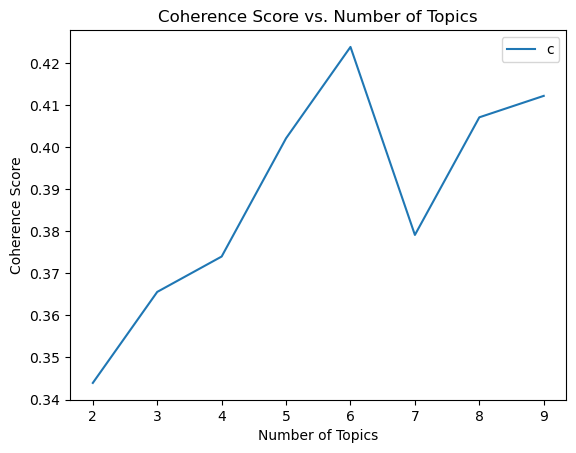

In [10]:
# Plot the coherence values
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.title("Coherence Score vs. Number of Topics")
plt.show()

In [58]:
### LDA Model

from gensim.models import LdaModel
import gensim.corpora as corpora

# Create a Gensim corpus from the term-document matrix
# gensim_corpus = [corpora.MmCorpus.serialize('corpus.mm', corpus)]

# Build the LDA model
num_topics = 8  # Adjust the number of topics as needed
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=50) #Increasing the number of passes during training can lead to more stable results

# Print the topics and associated words
topics = lda_model.print_topics(num_words=5)  # Adjust the number of words per topic as needed

for topic in topics:
    print(topic)

(0, '0.002*"None." + 0.002*"all" + 0.002*"All" + 0.002*" " + 0.002*"Na"')
(1, '0.022*"all" + 0.022*"None." + 0.009*" " + 0.008*"Na" + 0.006*"none available"')
(2, '0.002*"None." + 0.002*"all" + 0.002*" " + 0.002*"Na" + 0.002*"Unsure."')
(3, '0.002*"None." + 0.002*"all" + 0.002*" " + 0.002*"Na" + 0.002*"None at this time."')
(4, '0.002*"all" + 0.002*"None." + 0.002*" " + 0.002*"Na" + 0.002*"All"')
(5, '0.002*"None." + 0.002*"all" + 0.002*" " + 0.002*"Na" + 0.002*"none available"')
(6, '0.002*"None." + 0.002*"all" + 0.002*"Na" + 0.002*"None at this time." + 0.002*" "')
(7, '0.002*"all" + 0.002*"None." + 0.002*" " + 0.002*"Na" + 0.002*"None at this time."')


1. Words with higher scores within a topic are more indicative of that topic's content. For example, in Topic 0, "cours" and "valuabl" are more strongly associated with the topic compared to other words.
2. The scores themselves are not limited to a maximum value of 1. They depend on the distribution of words within the dataset and the number of topics specified in the LDA model. 


In [59]:
### Print each document (optional)

original_text = df['Learner Response']

for doc_id, text in enumerate(df['Learner Response']):
    print(f"Document {doc_id}: {text}")

Document 0: The entire course was valuable to me.  I had very little knowledge of disaster planning before taking the course.
Document 1: I had difficulty navigating the course content and no clear understanding of the course directions.
Document 2: The resource section with their many tools.
Document 3: disaster pre-programming steps. 
Document 4: I don't think you can seriously tell me that a parish in New Orleans that is at or below sea level and surrounded by water doesn't have a flood risk. That question/answer is flawed. It goes back to that mapping tool issue, because the tool says Charleston has a low risk of flooding and it floods here all the time (including on sunny days). Maybe the tool needs to be recalibrated. In any event, I thought the training was good, and very similar to FEMA courses I've taken in the past.   
Document 5: One of the mapping tools, because it didn't seem to function properly. 
Document 6: All equally valuable. Quizzes are a good way to make sure I'm g

In [61]:
### Check the topic that each document belongs to (optional)

# Use Gensim's LDA model, which returns a list of topics for a document along with their corresponding probabilities. 
# The topic with the highest probability is the one to which the document is most strongly related.
# Assign topics to each document
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]

#Print the topics for each document
for doc_id, topics in enumerate(document_topics):
    print(f"Document {doc_id}:")
    for topic_id, topic_probability in topics:
        print(f"Topic {topic_id}: Probability {topic_probability}")

Document 0:
Topic 1: Probability 0.998217761516571


Document 1:
Topic 0: Probability 0.022519242018461227
Topic 1: Probability 0.02232515625655651
Topic 2: Probability 0.022326888516545296
Topic 3: Probability 0.022240517660975456
Topic 4: Probability 0.9105881452560425

In this case, Topic 4 with a probability of 0.91 is the dominant topic for the document 1. This means that the document 1 is most likely about or related to Topic 4.

In [62]:
### Basic Statistics

from nltk.tokenize import word_tokenize

# Tokenize the 'Learner Response' column and count the tokens for each document
df['Word Count'] = df['Learner Response'].apply(lambda x: len(word_tokenize(x)))

# Print the document ID and the corresponding word count
# for doc_id, word_count in df['Word Count'].iteritems():
#     print(f"Document {doc_id}: Word Count = {word_count}")

# Calculate the average word count
average_word_count = df['Word Count'].mean()
average_word_count

11.138775510204082

In [63]:
# Calculate the median word count
median_word_count = df['Word Count'].median()
median_word_count

8.0

In [64]:
# # Calculate the 95th percentile of word count
# percentile_95 = df['Word Count'].quantile(0.95)

# # Print the minimum word count
# print(f'Minimum Word Count for 95% of Narratives: {percentile_95:.2f}')

1. The average number of words among all documents is 11.14, and the median is 8. 
2. More than 95% of the narratives have length of at least XX words which is large enough to be analyzed by LDA. Consequently, the documents with total number of words less than XX were removed from our analysis.

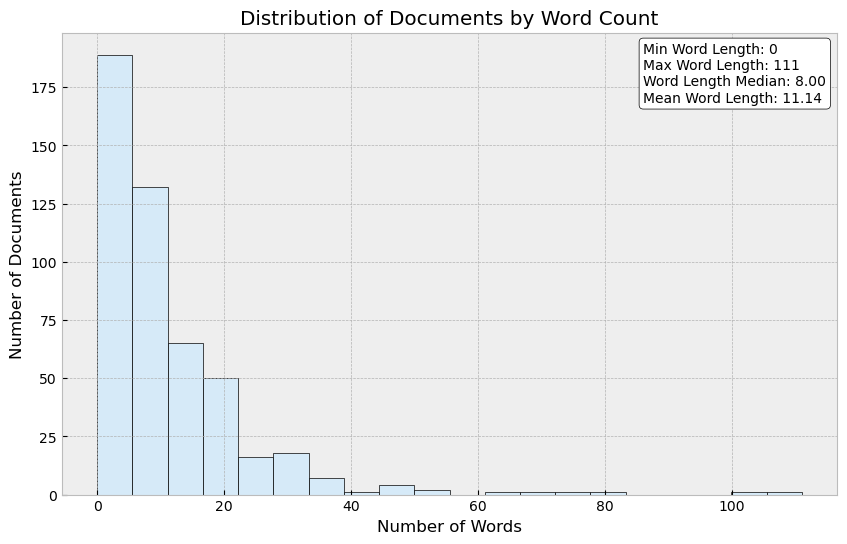

In [65]:
### Distribution of documents by word counts

import matplotlib.pyplot as plt
import pandas as pd

# Apply the 'bmh' style
plt.style.use('bmh')

# Create a histogram to show the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['Word Count'], bins=20, edgecolor='k', color='#D6EAF8')
plt.title('Distribution of Documents by Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Number of Documents')
plt.grid(True)

# Add information to the graph
min_word_length = df['Word Count'].min()
max_word_length = df['Word Count'].max()
median_word_length = df['Word Count'].median()
mean_word_length = df['Word Count'].mean()

info_text = f"Min Word Length: {min_word_length}\nMax Word Length: {max_word_length}\nWord Length Median: {median_word_length:.2f}\nMean Word Length: {mean_word_length:.2f}"

plt.text(0.75, 0.85, info_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.show()

In [66]:
### Intertopic Distance Plot

# from gensim.models import LdaModel
# import gensim.corpora as corpora
# import pyLDAvis.gensim

# # Create the visualization
# pyLDAvis.enable_notebook()  # To enable the visualization in Jupyter Notebook
# #vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
# vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, n_jobs=1)


# # Display the visualization
# pyLDAvis.display(vis_data)

TypeError: Object of type complex is not JSON serializable

In [16]:
### Word Embedding

# from gensim.models import Word2Vec

# # Train a Word2Vec model on your preprocessed text data
# model_w2v = Word2Vec(df['preprocessed_text'], vector_size=100, window=5, min_count=1, sg=0)

# # 'df['preprocessed_text']' should be a list of lists where each list represents a preprocessed document.

# # Save the Word2Vec model (optional)
# model_w2v.save("word2vec_model")

# # Load the Word2Vec model (if needed)
# # model_w2v = Word2Vec.load("word2vec_model")

# # Access word embeddings for specific words
# word_vector = model_w2v.wv['example_word']

In [24]:
### How to determine the number of topics
### Compare time perplexity and elapsed time
import gensim
import time
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

Number of Topics: 2, Perplexity: -6.288596355999434, Time Elapsed: 1.230942964553833 seconds
Number of Topics: 3, Perplexity: -6.37823857821414, Time Elapsed: 1.0429880619049072 seconds
Number of Topics: 4, Perplexity: -6.4776400633899645, Time Elapsed: 0.9655511379241943 seconds
Number of Topics: 5, Perplexity: -6.527065608719011, Time Elapsed: 0.9405701160430908 seconds
Number of Topics: 6, Perplexity: -6.616904789740722, Time Elapsed: 0.8547399044036865 seconds
Number of Topics: 7, Perplexity: -6.65476408138321, Time Elapsed: 0.8336451053619385 seconds
Number of Topics: 8, Perplexity: -6.6743198921864355, Time Elapsed: 0.823822021484375 seconds
Number of Topics: 9, Perplexity: -6.7216284590177775, Time Elapsed: 0.7843270301818848 seconds
Number of Topics: 10, Perplexity: -6.749216182765985, Time Elapsed: 0.7900390625 seconds


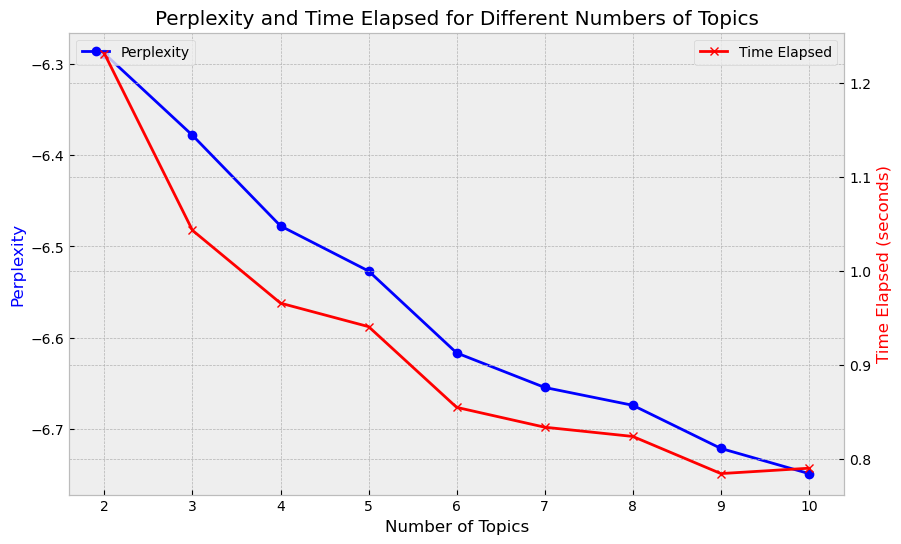

In [23]:
# Define the range of possible topic numbers to explore
num_topics_range = range(2, 11)  # Adjust the range as needed

# Initialize lists to store perplexity and elapsed time values
perplexity_values = []
elapsed_time_values = []

for num_topics in num_topics_range:
    start_time = time.time()

    # Create an LDA model
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

    # Measure the time elapsed
    elapsed_time = time.time() - start_time

    # Calculate the perplexity
    perplexity = lda_model.log_perplexity(corpus)
    
    # Append values to the respective lists
    perplexity_values.append(perplexity)
    elapsed_time_values.append(elapsed_time)

    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}, Time Elapsed: {elapsed_time} seconds")

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, perplexity_values, marker='o', label='Perplexity', color='blue')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity', color='blue')
plt.legend(loc='upper left')

# Create a second y-axis for time elapsed
ax2 = plt.twinx()
ax2.plot(num_topics_range, elapsed_time_values, marker='x', label='Time Elapsed', color='red')
ax2.set_ylabel('Time Elapsed (seconds)', color='red')
plt.legend(loc='upper right')

plt.title('Perplexity and Time Elapsed for Different Numbers of Topics')
plt.xticks(num_topics_range)
plt.show()

In [18]:
# Define a range of possible topic numbers to explore
num_topics_range = range(2, 11)  # Adjust the range as needed

for num_topics in num_topics_range:
    start_time = time.time()
    
    # Create an LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    
    # Measure the time elapsed
    elapsed_time = time.time() - start_time
    
    # Calculate the perplexity
    perplexity = lda_model.log_perplexity(corpus)
    
    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}, Time Elapsed: {elapsed_time} seconds")

Number of Topics: 2, Perplexity: -6.26488256461317, Time Elapsed: 1.128396987915039 seconds
Number of Topics: 3, Perplexity: -6.380326575312102, Time Elapsed: 1.0608787536621094 seconds
Number of Topics: 4, Perplexity: -6.481455605686181, Time Elapsed: 0.9927430152893066 seconds
Number of Topics: 5, Perplexity: -6.5522683873344665, Time Elapsed: 0.9548280239105225 seconds
Number of Topics: 6, Perplexity: -6.620612565714348, Time Elapsed: 0.8867478370666504 seconds
Number of Topics: 7, Perplexity: -6.667667724229057, Time Elapsed: 0.8271958827972412 seconds
Number of Topics: 8, Perplexity: -6.676163172354902, Time Elapsed: 0.8034780025482178 seconds
Number of Topics: 9, Perplexity: -6.764788305096688, Time Elapsed: 0.8009440898895264 seconds
Number of Topics: 10, Perplexity: -6.737801852874707, Time Elapsed: 0.767282247543335 seconds


1. Generally, lower perplexity values are better, but there's a trade-off with interpretability.
2. The perplexity values are decreasing as the number of topics increases. This is expected, as a higher number of topics can provide a better fit to the data, resulting in lower perplexity. However, there is a trade-off between lower perplexity and the interpretability of the topics.
3. The time elapsed is generally decreasing as the number of topics increases. This is also expected because a smaller number of topics requires less computation. It's important to balance computational efficiency with model quality.